# M5 Data Download, Preparation, and Exploratory Analysis

This notebook performs a clean, reproducible pass through raw data acquisition, panel preparation, and core exploratory visualizations.

In [1]:
# 1. Imports & Setup (Root-Aware Paths)
import sys, os, json
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='whitegrid')

# Detect project root: assume this notebook lives under <root>/notebooks/
NB_PATH = Path(__file__).resolve() if '__file__' in globals() else Path.cwd()
# If running interactively, ascend until we find a marker file (README.md or environment.yml)
root_candidates = [p for p in NB_PATH.parents if (p / 'README.md').exists() or (p / 'environment.yml').exists()]
PROJECT_ROOT = root_candidates[0] if root_candidates else NB_PATH
print('Detected project root:', PROJECT_ROOT)

DATA_ROOT = PROJECT_ROOT / 'data'
RAW_DIR = DATA_ROOT / 'raw' / 'm5'
PROCESSED_DIR = DATA_ROOT / 'processed' / 'm5_panel'
RAW_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
print('Raw dir:', RAW_DIR)
print('Processed dir:', PROCESSED_DIR)
print('Python', sys.version)

Detected project root: /Users/zak/Repos/E-commerce-Demand-Forecasting
Raw dir: /Users/zak/Repos/E-commerce-Demand-Forecasting/data/raw/m5
Processed dir: /Users/zak/Repos/E-commerce-Demand-Forecasting/data/processed/m5_panel
Python 3.11.13 (main, Jun  5 2025, 08:21:08) [Clang 14.0.6 ]


In [2]:
# 2. Kaggle Download (Skip if files exist)
import subprocess
REQUIRED = ["calendar.csv","sales_train_validation.csv","sell_prices.csv","sample_submission.csv"]
missing = [f for f in REQUIRED if not (RAW_DIR / f).exists()]
if missing:
    print('Missing files, attempting download of each:', missing)
    for f in REQUIRED:
        if not (RAW_DIR / f).exists():
            cmd = ["kaggle","competitions","download","-c","m5-forecasting-accuracy","-f",f,"-p",str(RAW_DIR)]
            print('Running', ' '.join(cmd))
            subprocess.run(cmd)
    # unzip all zips
    for z in RAW_DIR.glob('*.zip'):
        subprocess.run(["unzip","-o",str(z),"-d",str(RAW_DIR)])
        z.unlink()
else:
    print('All required raw files present; skipping download.')

All required raw files present; skipping download.


In [5]:
# 3. Load Raw Files (Integrity Diagnostics Updated)
from pathlib import Path
import pandas as pd
import chardet
from pandas.errors import ParserError
import os

print('Using RAW_DIR from setup:', RAW_DIR)
EXPECTED_SALES_PREFIX = 'd_'
EXPECTED_DAY_COLUMNS = 1913  # validation horizon days in wide train
MIN_DAY_COLUMNS_THRESHOLD = 1800  # allow slight variance but flag if below this

REQUIRED_FILES = [
    'calendar.csv',
    'sell_prices.csv',
    'sales_train_validation.csv',
]
OPTIONAL_FILES = ['sales_train_evaluation.csv', 'sample_submission.csv']

missing = [f for f in REQUIRED_FILES if not (RAW_DIR / f).exists()]
if missing:
    print('Missing required raw files:', missing)
    print('Run Cell 2 to download them before proceeding.')
    raise SystemExit('Aborting load; raw files missing.')

# Approximate expected uncompressed size ranges (MB)
APPROX_SIZE_MB = {
    'calendar.csv': (0.09, 0.12),
    'sell_prices.csv': (180, 210),
    'sales_train_validation.csv': (100, 130),
    'sales_train_evaluation.csv': (100, 130),
    'sample_submission.csv': (4, 7),
}

print('Raw file sizes:')
for name, rng in APPROX_SIZE_MB.items():
    p = RAW_DIR / name
    if p.exists():
        sz = p.stat().st_size / 1e6
        low, high = rng
        status = 'OK' if (low <= sz <= high) else f'OUT_OF_RANGE({sz:.2f})'
        print(f'  {name}: {sz:.2f} MB expected ~[{low:.2f},{high:.2f}] -> {status}')
    else:
        label = 'MISSING (optional)' if name in OPTIONAL_FILES else 'MISSING'
        print(f'  {name}: {label}')


def detect_encoding(path: Path):
    with open(path, 'rb') as f:
        sample = f.read(100000)
    info = chardet.detect(sample)
    return info.get('encoding') or 'ISO-8859-1'

def load_csv_iterative(path: Path, check_days=False):
    strategies = [
        {'encoding': None, 'engine': None, 'on_bad_lines': None, 'label': 'utf-8'},
        {'encoding': detect_encoding(path), 'engine': None, 'on_bad_lines': None, 'label': 'detected'},
        {'encoding': detect_encoding(path), 'engine': 'python', 'on_bad_lines': 'skip', 'label': 'python-skip'},
    ]
    last_error = None
    for s in strategies:
        try:
            kwargs = {}
            if s['encoding']:
                kwargs['encoding'] = s['encoding']
            if s['engine']:
                kwargs['engine'] = s['engine']
            if s['on_bad_lines']:
                kwargs['on_bad_lines'] = s['on_bad_lines']
            print(f"Loading {path.name} strategy={s['label']}")
            df = pd.read_csv(path, **kwargs)
            if check_days:
                day_cols = [c for c in df.columns if c.startswith(EXPECTED_SALES_PREFIX)]
                print(f"Found {len(day_cols)} day columns")
            return df
        except (UnicodeDecodeError, ParserError, Exception) as e:
            last_error = e
            print(f"Strategy {s['label']} failed: {e.__class__.__name__}: {e}")
            continue
    raise RuntimeError(f"Failed to load {path.name}; last error: {last_error}\nRe-download via Cell 2.")

calendar = load_csv_iterative(RAW_DIR / 'calendar.csv')
sales_validation = load_csv_iterative(RAW_DIR / 'sales_train_validation.csv', check_days=True)
prices = load_csv_iterative(RAW_DIR / 'sell_prices.csv')
# Optional evaluation file
sales_eval_path = RAW_DIR / 'sales_train_evaluation.csv'
sales_eval_df = None
if sales_eval_path.exists():
    try:
        sales_eval_df = load_csv_iterative(sales_eval_path, check_days=True)
    except Exception as e:
        print('Optional evaluation file failed to load:', e)

print('calendar shape', calendar.shape)
print('validation wide shape', sales_validation.shape)
print('prices shape', prices.shape)
if sales_eval_df is not None:
    print('evaluation wide shape', sales_eval_df.shape)

val_day_cols = [c for c in sales_validation.columns if c.startswith(EXPECTED_SALES_PREFIX)]
if len(val_day_cols) < MIN_DAY_COLUMNS_THRESHOLD:
    raise RuntimeError(f"Unexpected day column count {len(val_day_cols)} (<{MIN_DAY_COLUMNS_THRESHOLD}); file likely corrupted. Re-download required.")
else:
    print(f"Day column count OK: {len(val_day_cols)}")

calendar.head()

Using RAW_DIR from setup: /Users/zak/Repos/E-commerce-Demand-Forecasting/data/raw/m5
Raw file sizes:
  calendar.csv: 0.10 MB expected ~[0.09,0.12] -> OK
  sell_prices.csv: 203.40 MB expected ~[180.00,210.00] -> OK
  sales_train_validation.csv: 120.01 MB expected ~[100.00,130.00] -> OK
  sales_train_evaluation.csv: 121.74 MB expected ~[100.00,130.00] -> OK
  sample_submission.csv: 5.23 MB expected ~[4.00,7.00] -> OK
Loading calendar.csv strategy=utf-8
Loading sales_train_validation.csv strategy=utf-8
Found 1913 day columns
Loading sell_prices.csv strategy=utf-8
Found 1913 day columns
Loading sell_prices.csv strategy=utf-8
Loading sales_train_evaluation.csv strategy=utf-8
Loading sales_train_evaluation.csv strategy=utf-8
Found 1941 day columns
calendar shape (1969, 14)
validation wide shape (30490, 1919)
prices shape (6841121, 4)
evaluation wide shape (30490, 1947)
Day column count OK: 1913
Found 1941 day columns
calendar shape (1969, 14)
validation wide shape (30490, 1919)
prices shape 

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [8]:
# 4. Melt Wide Sales to Long (Sample Subset)
# Use the loaded sales_validation wide frame; ensure item_id column exists.
wide = sales_validation.copy()

# If Kaggle format stores identifiers differently, reconstruct item_id.
# Typical columns: id, item_id, dept_id, cat_id, store_id, state_id, d_1 ... d_1913
if 'item_id' not in wide.columns and 'id' in wide.columns:
    # id pattern: HOBBIES_1_001_CA_1_validation -> item_id is first 3 segments joined
    def extract_item(row_id: str) -> str:
        parts = row_id.split('_')
        # M5 item_id normally: <cat>_<dept>_<itemNumber>
        if len(parts) >= 3:
            return '_'.join(parts[0:3])
        return row_id
    wide['item_id'] = wide['id'].apply(extract_item)
    print('Derived item_id from id column.')

if 'item_id' not in wide.columns:
    raise RuntimeError('Unable to determine item_id column in wide sales data.')

# Subset items for memory safety
subset_item_ids = wide['item_id'].unique()[:200]
subset = wide[wide['item_id'].isin(subset_item_ids)]
value_cols = [c for c in subset.columns if c.startswith('d_')]
id_cols = [c for c in subset.columns if c not in value_cols]

long = subset.melt(id_vars=id_cols, value_vars=value_cols, var_name='d', value_name='demand')
print('Long subset shape', long.shape)
print('Columns:', long.columns.tolist()[:15])
long.head()

Long subset shape (3826000, 8)
Columns: ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'demand']


,id,item_id,dept_id,cat_id,store_id,state_id,d,demand
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [9]:
# 5. Join Calendar to Get Dates
long = long.merge(calendar[['d','date','wm_yr_wk','weekday','wday','month','year']], on='d', how='left')
long['date'] = pd.to_datetime(long['date'])
print('Post calendar join shape', long.shape)
long.head()

Post calendar join shape (3826000, 14)


,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,weekday,wday,month,year
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011


In [10]:
# 6. Join Sell Prices
prices_subset = prices[prices['item_id'].isin(subset_item_ids)]
long = long.merge(prices_subset[['store_id','item_id','wm_yr_wk','sell_price']], on=['store_id','item_id','wm_yr_wk'], how='left')
print('After price join shape', long.shape)
print(long[['sell_price']].describe())

After price join shape (3826000, 15)
         sell_price
count  3.068572e+06
mean   6.389991e+00
std    5.080513e+00
min    2.400000e-01
25%    2.570000e+00
50%    4.970000e+00
75%    9.420000e+00
max    3.098000e+01


In [11]:
# 7. Basic Demand Aggregations
by_date = long.groupby('date')['demand'].sum().reset_index()
by_item = long.groupby('item_id')['demand'].sum().reset_index().sort_values('demand', ascending=False)
print('Top items by total demand:')
print(by_item.head())
by_date.head()

Top items by total demand:
           item_id  demand
173  HOBBIES_1_178   90433
7    HOBBIES_1_008   87645
14   HOBBIES_1_015   84541
47   HOBBIES_1_048   75717
98   HOBBIES_1_103   71019


,date,demand
0,2011-01-29,1392
1,2011-01-30,1228
2,2011-01-31,942
3,2011-02-01,1022
4,2011-02-02,686


Saved artifacts/figures/daily_demand_subset.png


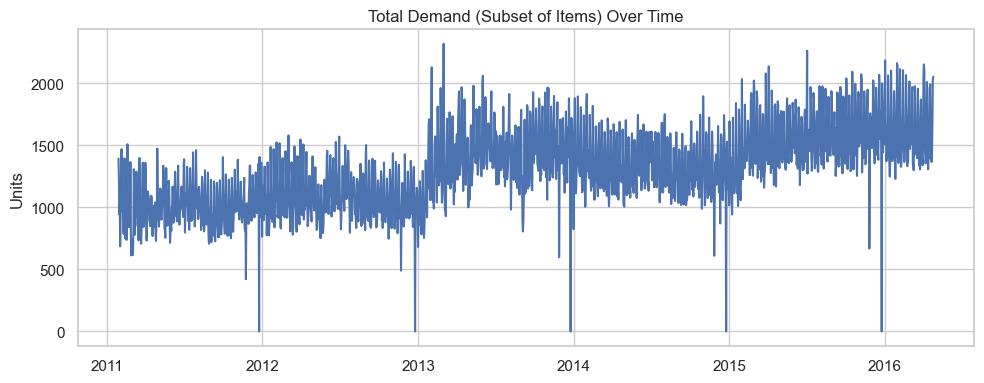

In [15]:
# 8. Plot Daily Demand Over Time (Subset)
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(by_date['date'], by_date['demand'])
ax.set_title('Total Demand (Subset of Items) Over Time')
ax.set_ylabel('Units')
fig.tight_layout()
FIG_DIR = Path('artifacts/figures'); FIG_DIR.mkdir(parents=True, exist_ok=True)
fig_path = FIG_DIR / 'daily_demand_subset.png'
fig.savefig(fig_path)
print('Saved', fig_path)
# Display the figure inline
plt.show()
# Optionally close to free memory after rendering
plt.close(fig)

Saved artifacts/figures/price_vs_demand_HOBBIES_1_001.png


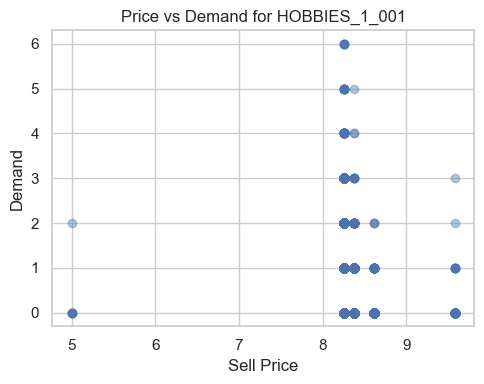

In [17]:
# 9. Price vs Demand Scatter (Sample Item)
sample_item = subset_item_ids[0]
item_df = long[long['item_id'] == sample_item]
fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(item_df['sell_price'], item_df['demand'], alpha=0.4)
ax.set_title(f'Price vs Demand for {sample_item}')
ax.set_xlabel('Sell Price')
ax.set_ylabel('Demand')
fig.tight_layout()
fig_path = FIG_DIR / f'price_vs_demand_{sample_item}.png'
fig.savefig(fig_path)
print('Saved', fig_path)
# Display the figure inline
plt.show()
# Optionally close to free memory after rendering
plt.close(fig)

Saved artifacts/figures/rolling_means_HOBBIES_1_001.png


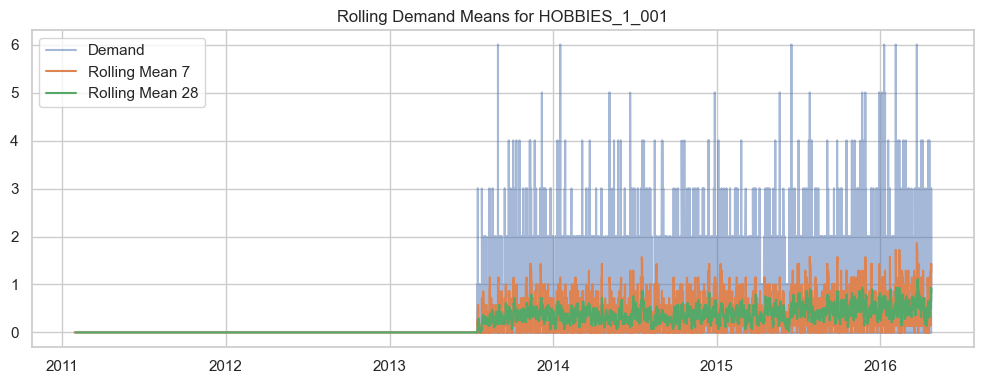

In [18]:
# 10. Rolling Statistics Example
item_df = item_df.sort_values('date')
item_df['rolling_mean_7'] = item_df['demand'].rolling(7).mean()
item_df['rolling_mean_28'] = item_df['demand'].rolling(28).mean()
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(item_df['date'], item_df['demand'], label='Demand', alpha=0.5)
ax.plot(item_df['date'], item_df['rolling_mean_7'], label='Rolling Mean 7')
ax.plot(item_df['date'], item_df['rolling_mean_28'], label='Rolling Mean 28')
ax.legend()
ax.set_title(f'Rolling Demand Means for {sample_item}')
fig.tight_layout()
fig_path = FIG_DIR / f'rolling_means_{sample_item}.png'
fig.savefig(fig_path)
print('Saved', fig_path)
# Display the figure inline
plt.show()
# Optionally close to free memory after rendering
plt.close(fig)

In [ ]:
# 11. Save Subset Panel to Parquet
# Use PROJECT_ROOT to ensure we write to the root-level data/processed directory, not notebooks/data/processed
panel_out = PROJECT_ROOT / 'data' / 'processed' / 'm5_panel_subset.parquet'
panel_out.parent.mkdir(parents=True, exist_ok=True)
long.to_parquet(panel_out, index=False)
print('Saved subset panel parquet at', panel_out, 'size bytes', panel_out.stat().st_size)

OSError: Cannot save file into a non-existent directory: 'data/processed'

In [ ]:
# 12. Summary & Next Steps
summary = {
    'n_subset_items': int(len(subset_item_ids)),
    'n_rows_long': int(len(long)),
    'date_range': (str(long['date'].min().date()), str(long['date'].max().date())),
    'panel_out': str(panel_out),
}
print(json.dumps(summary, indent=2))